In [33]:
include("utils/preprocessing.jl")
include("utils/model_evaluation.jl")
include("utils/data_loader.jl")
include("utils/visualization.jl")
include("utils/ml1_utils.jl")

evaluateAndPrintMetricsRanking (generic function with 1 method)

In [34]:
# import Pkg;
# Pkg.add("Random")
# Pkg.add("MLBase")
# Pkg.add("JLD")
# Pkg.add("ScikitLearn")

""" 
    Make it ignore all warnings    
"""

using Random
Random.seed!(123)
using ScikitLearn
using JLD

## DESCRIPTION OF APPROACH ##

##### LOAD THE DATA #####

In [35]:
data = DataLoader.load_data("dataset\\star_classification.csv");

##### (OPTIONAL) REDUCE THE DATASET #####

##### PREPROCESSING THE DATASET #####

In [36]:
# preprocess_data(dataset, reducing_ratio, holdOut ratio, normalization method, balancing_dataset, features)
train_inputs, train_targets, test_inputs, test_targets = Preprocessing.preprocess_data(data, 0.1, 0.2, "zero_mean", true, [4,5,6,7,8,15])

"""    This function does the following:
        - Balance the data using the undersampling method if chosen to do so
        - Parse the data: chosing the correct columns for inputs and targets (Shouldn't this be done before balancing??)
        - Splits the data into training and testing using holdOut method
        - Normalize the inputs
"""

# Print first input and target
println("First input: ", train_inputs[1, :])
println("First target: ", train_targets[1, :])

First input: Float32[-0.18184435, -0.1063038, 0.32182, 0.5550667, 0.76979786, -0.76223695]
First target: Any["STAR"]


In [37]:
""" 
This would be cooler to have in the preprocess_data function
but I've tried and failed miserably
"""

@sk_import decomposition:PCA

pca = PCA(0.95)
fit!(pca, train_inputs)

#Once it is ajusted it can be used to transform the data
train_inputs = pca.transform(train_inputs)
test_inputs = pca.transform(test_inputs)

print("Train Patterns ", size(train_inputs))
print("Train Patterns ", size(test_inputs))

Train Patterns (4553, 3)Train Patterns (1138, 3)

## Testing hyperparameters for each model ##

In [38]:
@sk_import neural_network: MLPClassifier;
@sk_import svm: SVC;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;
@sk_import ensemble: RandomForestClassifier;
@sk_import ensemble: StackingClassifier;
@sk_import metrics: accuracy_score;

In [39]:
"""
Setting indices for the k-fold cross-validation
    we are about to do with the different models
"""
N=size(train_inputs,1)
k = 5 # number of folds
kFoldIndices = crossvalidation(N, k);

##### DECISION TREE #####

In [40]:
# Define an array of hyperparameter dictionaries for the Decision Tree model
dtree_hyperparameters_array = [
    Dict("max_depth" => 3),
    Dict("max_depth" => 5),
    Dict("max_depth" => 10),
    Dict("max_depth" => 20),
    Dict("max_depth" => 50),
    Dict("max_depth" => 100) # Deeper trees can capture more detail but risk overfitting
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:DecisionTree,dtree_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc -----
Set of hyperparameters 3 -> mean: 0.887 Std. Dev.: 0.006
Set of hyperparameters 4 -> mean: 0.887 Std. Dev.: 0.007
Set of hyperparameters 5 -> mean: 0.887 Std. Dev.: 0.007
Set of hyperparameters 6 -> mean: 0.887 Std. Dev.: 0.007
Set of hyperparameters 2 -> mean: 0.827 Std. Dev.: 0.008
Set of hyperparameters 1 -> mean: 0.791 Std. Dev.: 0.009

----- sensitivity -----
Set of hyperparameters 3 -> mean: 0.887 Std. Dev.: 0.006
Set of hyperparameters 4 -> mean: 0.887 Std. Dev.: 0.007
Set of hyperparameters 5 -> mean: 0.887 Std. Dev.: 0.007
Set of hyperparameters 6 -> mean: 0.887 Std. Dev.: 0.007
Set of hyperparameters 2 -> mean: 0.827 Std. Dev.: 0.008
Set of hyperparameters 1 -> mean: 0.791 Std. Dev.: 0.009

----- specificity -----
Set of hyperpar

##### kNN #####

In [41]:
# Define an array of hyperparameter dictionaries for the kNN model
knn_hyperparameters_array = [
    Dict("n_neighbors" => 5),
    Dict("n_neighbors" => 10),
    Dict("n_neighbors" => 15),
    Dict("n_neighbors" => 20),
    Dict("n_neighbors" => 50),
    Dict("n_neighbors" => 100) # Large neighborhoods, smooths out predictions
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:kNN,knn_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc -----
Set of hyperparameters 1 -> mean: 0.925 Std. Dev.: 0.005
Set of hyperparameters 2 -> mean: 0.91 Std. Dev.: 0.006
Set of hyperparameters 3 -> mean: 0.908 Std. Dev.: 0.009
Set of hyperparameters 4 -> mean: 0.9 Std. Dev.: 0.005
Set of hyperparameters 5 -> mean: 0.879 Std. Dev.: 0.004
Set of hyperparameters 6 -> mean: 0.857 Std. Dev.: 0.005

----- sensitivity -----
Set of hyperparameters 1 -> mean: 0.925 Std. Dev.: 0.005
Set of hyperparameters 2 -> mean: 0.91 Std. Dev.: 0.006
Set of hyperparameters 3 -> mean: 0.908 Std. Dev.: 0.009
Set of hyperparameters 4 -> mean: 0.9 Std. Dev.: 0.005
Set of hyperparameters 5 -> mean: 0.879 Std. Dev.: 0.004
Set of hyperparameters 6 -> mean: 0.857 Std. Dev.: 0.005

----- specificity -----
Set of hyperparameter

##### SVM #####

In [42]:
svm_hyperparameters_array = [
    # Uses 'rbf' kernel, medium complexity with C=1.0, default polynomial degree, 'scale' for gamma 
    Dict("kernel" => "rbf", "degree" => 3, "C" => 1.0, "gamma" => "scale"),
    
    # Same 'rbf' kernel, increased penalty (C=10.0) for larger-margin separation, 'auto' gamma adjusts based on features
    Dict("kernel" => "rbf", "degree" => 3, "C" => 10.0, "gamma" => "auto"),
    
    # Same 'rbf' kernel, lower penalty (C=0.1) for a softer-margin, 'scale' gamma is default scaling
    Dict("kernel" => "rbf", "degree" => 3, "C" => 0.1, "gamma" => "scale"),

    # 'linear' kernel, suitable for less complex data
    Dict("kernel" => "linear", "degree" => 5,  "C" => 0.1, "gamma" => "auto"),
    
    # 'linear' kernel, not affected by 'degree' or 'gamma', with C=1.0 indicating a balance between margin and misclassification
    Dict("kernel" => "linear", "degree" => 3, "C" => 1.0, "gamma" => "auto"),

    # 'linear' kernel with a higher penalty, stricter margin
    Dict("kernel" => "linear", "degree" => 7, "C" => 10.0, "gamma" => "scale"),
    
    # 'poly' kernel, polynomial degree is set twice by mistake, should only be 'degree' => 3, 'scale' gamma defaults to feature scale
    Dict("kernel" => "poly", "degree" => 3, "C" => 1.0, "gamma" => "scale"),
    
    # 'poly' kernel, increased polynomial degree (5) for higher model complexity, 'auto' gamma may overfit with high dimension
    Dict("kernel" => "poly", "degree" => 5, "C" => 1.0, "gamma" => "auto")
]


# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:SVM, svm_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6
Training with set of hyperparameters 7
Training with set of hyperparameters 8

----- acc -----
Set of hyperparameters 2 -> mean: 0.956 Std. Dev.: 0.002
Set of hyperparameters 6 -> mean: 0.948 Std. Dev.: 0.005
Set of hyperparameters 5 -> mean: 0.937 Std. Dev.: 0.005
Set of hyperparameters 1 -> mean: 0.929 Std. Dev.: 0.006
Set of hyperparameters 3 -> mean: 0.885 Std. Dev.: 0.007
Set of hyperparameters 4 -> mean: 0.874 Std. Dev.: 0.005
Set of hyperparameters 7 -> mean: 0.824 Std. Dev.: 0.005
Set of hyperparameters 8 -> mean: 0.802 Std. Dev.: 0.006

----- sensitivity -----
Set of hyperparameters 2 -> mean: 0.956 Std. Dev.: 0.002
Set of hyperparameters 6 -> mean: 0.948 Std. Dev.: 0.005
Set of hyperparameters 5 -> mean: 0.937 Std. Dev.: 0.005
Set of hyperparamet

##### ANN #####

In [43]:
# Define an array of hyperparameter dictionaries for the ANN model
ann_hyperparameters_array = [
    # Two-layer architecture, moderate neurons
    Dict("architecture" => [50, 30], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer architecture, fewer neurons
    Dict("architecture" => [30], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # Two-layer, different activation function
    Dict("architecture" => [50, 30], "activation" => "tanh", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, lower learning rate
    Dict("architecture" => [30], "activation" => "relu", "learning_rate" => 0.001, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 2000, "repetitionsTraining" => 10),

    # Two-layer, higher learning rate
    Dict("architecture" => [50, 30], "activation" => "relu", "learning_rate" => 0.05, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, logistic activation
    Dict("architecture" => [30], "activation" => "logistic", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # Two-layer, more neurons, different activation
    Dict("architecture" => [70, 40], "activation" => "tanh", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, more neurons
    Dict("architecture" => [50], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10)
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:ANN, ann_hyperparameters_array, train_inputs, train_targets, kFoldIndices) 

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6
Training with set of hyperparameters 7
Training with set of hyperparameters 8

----- acc -----
Set of hyperparameters 7 -> mean: 0.963 Std. Dev.: 0.003
Set of hyperparameters 3 -> mean: 0.963 Std. Dev.: 0.003
Set of hyperparameters 1 -> mean: 0.961 Std. Dev.: 0.002
Set of hyperparameters 5 -> mean: 0.96 Std. Dev.: 0.002
Set of hyperparameters 8 -> mean: 0.959 Std. Dev.: 0.003
Set of hyperparameters 2 -> mean: 0.958 Std. Dev.: 0.003
Set of hyperparameters 6 -> mean: 0.956 Std. Dev.: 0.003
Set of hyperparameters 4 -> mean: 0.951 Std. Dev.: 0.004

----- sensitivity -----
Set of hyperparameters 7 -> mean: 0.963 Std. Dev.: 0.003
Set of hyperparameters 3 -> mean: 0.963 Std. Dev.: 0.003
Set of hyperparameters 1 -> mean: 0.961 Std. Dev.: 0.002
Set of hyperparamete

##### TRAINING MODELS WITH WHOLE DATASET #####

In [44]:
""" DECISION TREE MODEL """

# import Pkg; 
# Pkg.add("DecisionTree")
using DecisionTree


dt_model = DecisionTreeClassifier(max_depth=10)
println("After calling the model")

# Fit the model on the training data
ScikitLearn.fit!(dt_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = ScikitLearn.predict(dt_model, test_inputs)

# Calculate and print the accuracy
DT_acc, DT_error_rate, DT_sensitivity, DT_specificity, DT_PPV, DT_NPV, DT_F_score, DT_confusion = confusionMatrix(predicted_targets, test_targets)

println("Decision Tree model accuracy: $(DT_acc * 100) %")
println("Decision Tree model sensitivity: $(DT_sensitivity * 100) %")
println("Decision Tree model specificity: $(DT_specificity * 100) %")
println("Decision Tree model PPV: $(DT_PPV * 100) %")
println("Decision Tree model NPV: $(DT_NPV * 100) %")
println("Decision Tree model sensitivity: $(DT_F_score * 100) %")

# Save the model
#JLD.save("dt_model_3rd.jld", "model", dt_model)

After calling the model
Decision Tree model accuracy: 87.69771528998243 %
Decision Tree model sensitivity: 87.69771528998243 %
Decision Tree model specificity: 93.77491101856599 %
Decision Tree model PPV: 87.89024632962244 %
Decision Tree model NPV: 93.75358680874777 %
Decision Tree model sensitivity: 87.75306964241729 %


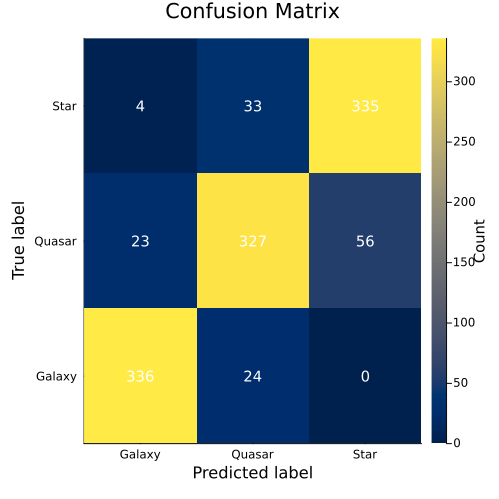

In [45]:
""" Printing the confusion matrix """
p0 = Visualization.plot_confusion_heatmap(DT_confusion)
display(p0)

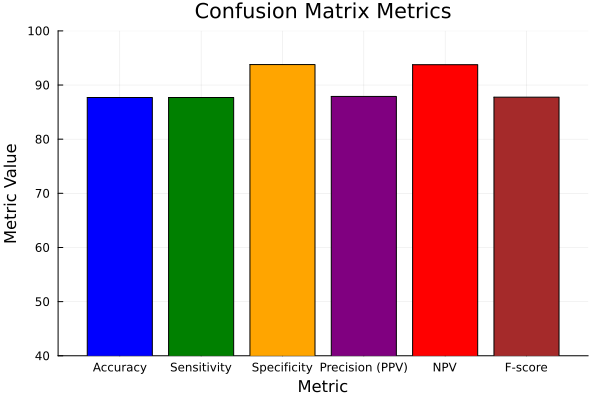

In [46]:
Visualization.plot_confusion_metrics(DT_acc, DT_sensitivity, DT_specificity, DT_PPV, DT_NPV, DT_F_score)

In [47]:
""" KNN MODEL """
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
ScikitLearn.fit!(knn_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = ScikitLearn.predict(knn_model, test_inputs)

# Calculate and print the accuracy
KNN_acc, KNN_error_rate, KNN_sensitivity, KNN_specificity, KNN_PPV, KNN_NPV, KNN_F_score, KNN_confusion = confusionMatrix(predicted_targets, test_targets)

println("KNN model accuracy: $(KNN_acc * 100) %")
println("KNN model sensitivity: $(KNN_sensitivity * 100) %")
println("KNN model specificity: $(KNN_specificity * 100) %")
println("KNN model PPV: $(KNN_PPV * 100) %")
println("KNN model NPV: $(KNN_NPV * 100) %")
println("KNN model sensitivity: $(KNN_F_score * 100) %")

# Save the model
#JLD.save("knn_model_3rd.jld", "model", knn_model)

KNN model accuracy: 91.82776801405976 %
KNN model sensitivity: 91.82776801405974 %
KNN model specificity: 95.85658292038164 %
KNN model PPV: 91.8402189377515 %
KNN model NPV: 95.94244407513017 %
KNN model sensitivity: 91.77956243686197 %


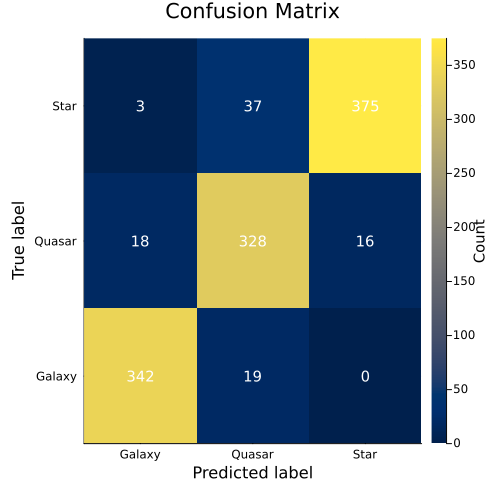

In [48]:
""" Printing the confusion matrix """
p1 = Visualization.plot_confusion_heatmap(KNN_confusion)
display(p1)

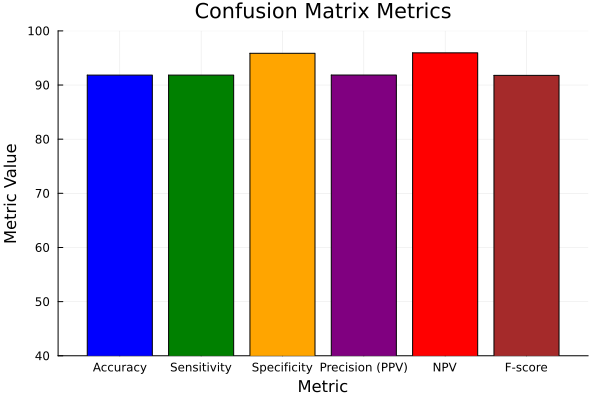

In [49]:
Visualization.plot_confusion_metrics(KNN_acc, KNN_sensitivity, KNN_specificity, KNN_PPV, KNN_NPV, KNN_F_score)

In [50]:
""" ANN MODEL """

using Random
Random.seed!(123)

ann_model = MLPClassifier(hidden_layer_sizes=(50, 30), activation="relu", learning_rate_init=0.01, validation_fraction=0.1, n_iter_no_change=80, max_iter=1000)

# Fit the model on the training data
ScikitLearn.fit!(ann_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = ScikitLearn.predict(ann_model, test_inputs)

# Calculate and print the accuracy
ANN_acc, ANN_error_rate, ANN_sensitivity, ANN_specificity, ANN_PPV, ANN_NPV, ANN_F_score, ANN_confusion = confusionMatrix(predicted_targets, test_targets)

println("ANN model accuracy: $(ANN_acc * 100) %")
println("ANN model sensitivity: $(ANN_sensitivity * 100) %")
println("ANN model specificity: $(ANN_specificity * 100) %")
println("ANN model PPV: $(ANN_PPV * 100) %")
println("ANN model NPV: $(ANN_NPV * 100) %")
println("ANN model sensitivity: $(ANN_F_score * 100) %")

# Save the model
#JLD.save("ann_model_3rd.jld", "model", ann_model)

ANN model accuracy: 95.16695957820738 %
ANN model sensitivity: 95.16695957820738 %
ANN model specificity: 97.63772311537463 %
ANN model PPV: 95.1850651311129 %
ANN model NPV: 97.62685176925612 %
ANN model sensitivity: 95.14466226175715 %


C:\Users\coros\.julia\conda\3\x86_64\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


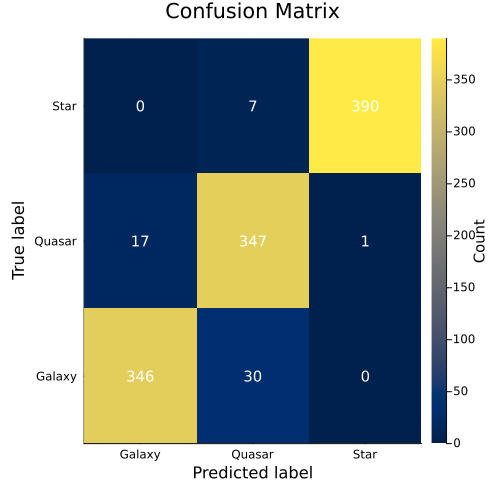

In [51]:
""" Printing the confusion matrix """
p2 = Visualization.plot_confusion_heatmap(ANN_confusion)
display(p2)

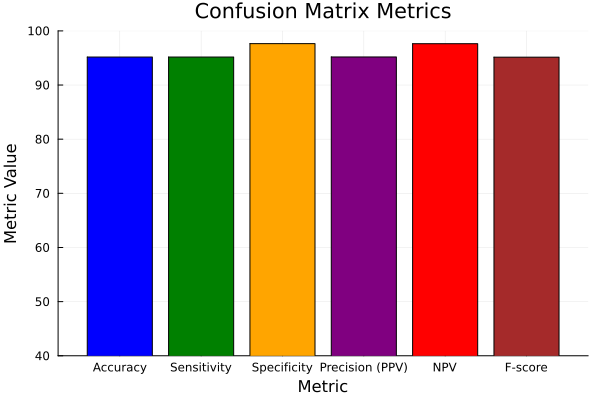

In [52]:
Visualization.plot_confusion_metrics(ANN_acc, ANN_sensitivity, ANN_specificity, ANN_PPV, ANN_NPV, ANN_F_score)

In [53]:
""" SVM MODEL """
svm_model = SVC(kernel = "rbf", degree = 3, C = 1.0, gamma = "scale")

# Fit the model on the training data
fit!(svm_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = predict(svm_model, test_inputs)

# Calculate and print the accuracy
SVM_acc, SVM_error_rate, SVM_sensitivity, SVM_specificity, SVM_PPV, SVM_NPV, SVM_F_score, SVM_confusion = confusionMatrix(predicted_targets, test_targets)

println("SVM model accuracy: $(SVM_acc * 100) %")
println("SVM model sensitivity: $(SVM_sensitivity * 100) %")
println("SVM model specificity: $(SVM_specificity * 100) %")
println("SVM model PPV: $(SVM_PPV * 100) %")
println("SVM model NPV: $(SVM_NPV * 100) %")
println("SVM model sensitivity: $(SVM_F_score * 100) %")

# Save the model
#JLD.save("svm_model_3rd.jld", "model", svm_model)

SVM model accuracy: 93.84885764499121 %
SVM model sensitivity: 93.84885764499121 %
SVM model specificity: 96.87289373977262 %
SVM model PPV: 93.94961354481626 %
SVM model NPV: 97.03255130076506 %
SVM model sensitivity: 93.78779722755442 %


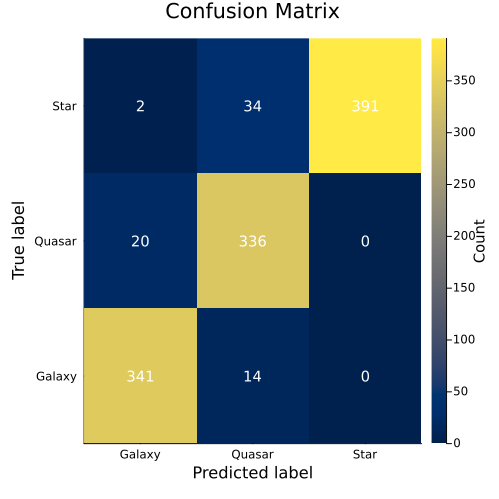

In [54]:
""" Printing the confusion matrix """
p3 = Visualization.plot_confusion_heatmap(SVM_confusion)
display(p3)

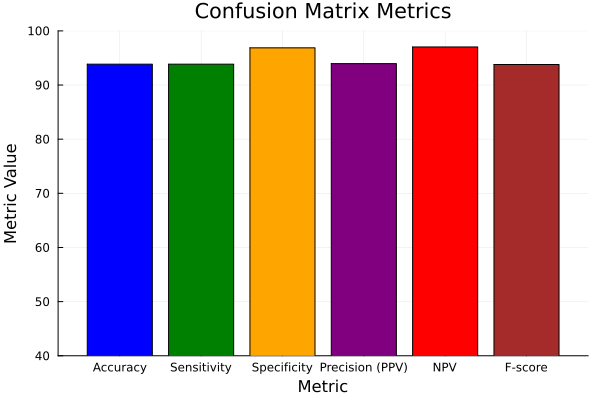

In [55]:
Visualization.plot_confusion_metrics(SVM_acc, SVM_sensitivity, SVM_specificity, SVM_PPV, SVM_NPV, SVM_F_score)

##### ENSEMBLE MODEL #####

In [56]:
using ScikitLearn
@sk_import metrics: accuracy_score

# Define the base models with the chosen hyperparameters
dt_model = DecisionTreeClassifier(max_depth=3)
knn_model = KNeighborsClassifier(n_neighbors=5)
ann_model = MLPClassifier(hidden_layer_sizes=(50, 30), activation="tanh", learning_rate_init=0.01, validation_fraction=0.1, n_iter_no_change=80, max_iter=10000) # Increase max_iter from 1000 to ensure convergence
svm_model = SVC(kernel="poly", degree=3, C=1.0, gamma="scale")

# Create a list of tuples (name, model) for the base models
base_models = [
    ("DecisionTree", dt_model),
    ("kNN", knn_model),
    ("ANN", ann_model),
    ("SVM", svm_model)
]

# Choose a final estimator for the stacking ensemble
# Logistic Regression is a common choice for combining predictions
final_estimator = RandomForestClassifier()

# Create the stacking ensemble
ensemble = StackingClassifier(estimators=base_models, final_estimator=final_estimator)

# Train the ensemble model
ScikitLearn.fit!(ensemble, train_inputs, train_targets)

# Evaluate the ensemble model
predicted_targets = ScikitLearn.predict(ensemble, test_inputs)
Ens_acc, Ens_error_rate, Ens_sensitivity, Ens_specificity, Ens_PPV, Ens_NPV, Ens_F_score, Ens_confusion = confusionMatrix(predicted_targets, test_targets)

println("Ensemble model accuracy: $(Ens_acc * 100) %")
println("Ensemble model sensitivity: $(Ens_sensitivity * 100) %")
println("Ensemble model specificity: $(Ens_specificity * 100) %")
println("Ensemble model PPV: $(Ens_PPV * 100) %")
println("Ensemble model NPV: $(Ens_NPV * 100) %")
println("Ensemble model sensitivity: $(Ens_F_score * 100) %")

# Save the model
#JLD.save("ensemble_3rd.jld", "model", ensemble)


Ensemble model accuracy: 95.69420035149385 %
Ensemble model sensitivity: 95.69420035149385 %
Ensemble model specificity: 97.85814221520201 %
Ensemble model PPV: 95.6697075600339 %
Ensemble model NPV: 97.89642803138233 %
Ensemble model sensitivity: 95.6707638434149 %


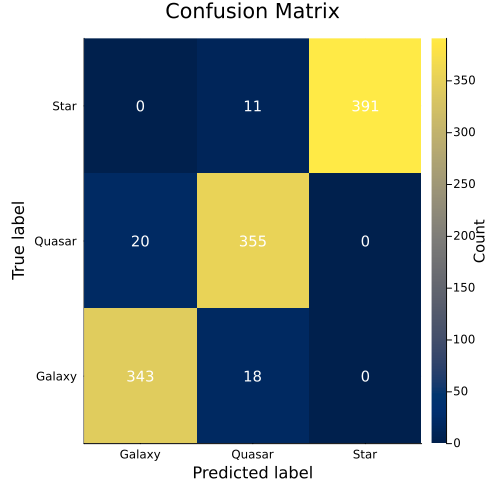

In [57]:
""" Printing the confusion matrix """
p4 = Visualization.plot_confusion_heatmap(Ens_confusion)
display(p4)

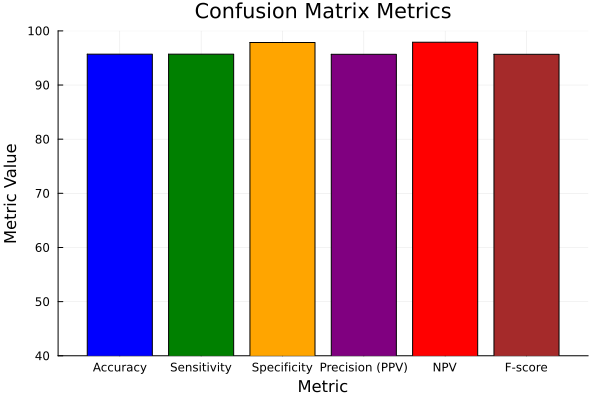

In [58]:
Visualization.plot_confusion_metrics(Ens_acc, Ens_sensitivity, Ens_specificity, Ens_PPV, Ens_NPV, Ens_F_score)